In [1]:
import os
import sys

if os.path.abspath('../src') not in sys.path:
    sys.path.append(os.path.abspath('../src'))

import time
from pathlib import Path

import pandas as pd
from datasets import load_dataset
from tqdm.auto import tqdm

from interface import MolRSmilesEmbedder


/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_PATH = Path('../saved/tag_1024')
DATA_PATH = Path("../../data/CS2/train.csv")  # Path to the dataset

embedder = MolRSmilesEmbedder(MODEL_PATH)
dataset = load_dataset('csv', data_files=str(DATA_PATH), split='train').select(range(10000))
emb_dataset = dataset.map(embedder, batched=True, batch_size=1024)
dimension = len(emb_dataset[0]['vector'])
print(f"embedding dimension: {dimension}")

embedding dimension: 1024


In [3]:
def time_vs_batch_size_datasets(embedding_processor, dataset, batch_sizes = [1024]):
    times = []
    for batch_size in tqdm(batch_sizes, leave=False, position=0):
        start = time.time()
        _ = dataset.map(
            embedding_processor,
            batched=True,
            batch_size=batch_size,
            with_rank=True,
            )
        end = time.time()
        times.append(end - start)
    res = pd.DataFrame({'batch_size': batch_sizes, 'time': times})
    res['time_per_mol'] = res['time'] / len(dataset)
    return res

In [4]:
results = time_vs_batch_size_datasets(embedder, dataset, batch_sizes=[64, 128, 256, 512, 1024, 2048])

Map: 100%|██████████| 10000/10000 [00:28<00:00, 346.89 examples/s]


<Axes: xlabel='batch_size'>

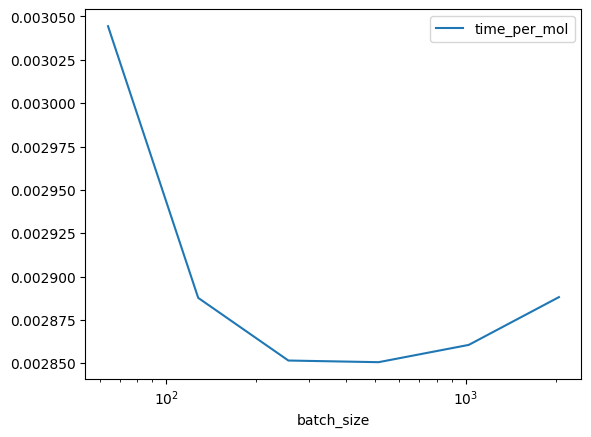

In [5]:
results.plot(x='batch_size', y='time_per_mol', logx=True)